In [1]:
!pip install pymongo

In [2]:
import math
#import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pymongo import MongoClient

Using TensorFlow backend.


In [3]:
# Create connection to MongoDb
client = MongoClient('mongodb://localhost:27017')
# Select stock_data database from mongoDB
db = client.stock_db

# Set up variable for input
input = 'AAPL'

# Gathering data
one_stock = db.stock_data.find_one({'symbol': input})

symbol = one_stock['symbol']
historical_data = one_stock['historical']

date = []
close = []

for h in historical_data:
    
    collect_dates = h['date']
    date.append(collect_dates)
    
    collect_close = h['close']
    close.append(collect_close)
    

In [4]:
df = pd.DataFrame({'Date': date,
                  'close': close})


df.head()

,Date,close
0,2021-02-26,121.260000
1,2021-02-25,120.989998
2,2021-02-24,125.349998
3,2021-02-23,125.860001
4,2021-02-22,126.000000


In [14]:
df['Date'] = pd.to_datetime(df['Date'])

df.dtypes

Date     datetime64[ns]
close           float64
dtype: object

In [15]:
sort_df = df.sort_values(by='Date', ascending=True)

new_df = sort_df.set_index('Date')

new_df.head()

,close
Date,
2016-02-29,24.172501
2016-03-01,25.132500
2016-03-02,25.187500
2016-03-03,25.375000
2016-03-04,25.752501


In [13]:
# # Maybe add user input variables for ticker and date?? 


# # Pull stock quote
# df = web.DataReader('SOS', data_source='yahoo', start='2010-01-01', end='2020-12-30')

# # Show df
# df


Date      object
close    float64
dtype: object

In [16]:
# Get the # of rows and col in df
new_df.shape

(1259, 1)

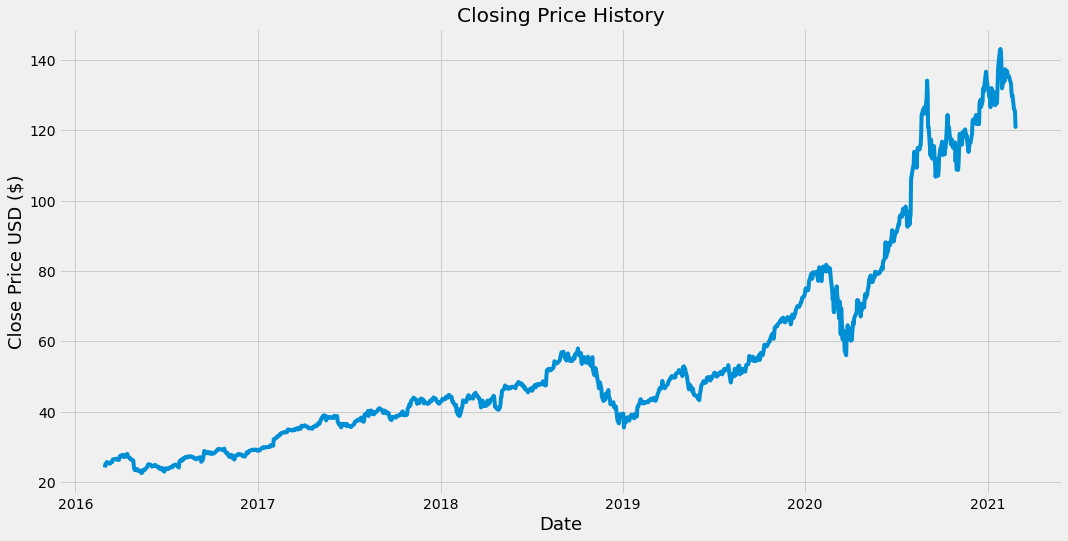

In [17]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(new_df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [38]:
# Create new df with only the 'Close' column
data = new_df.filter(['close'])

# Convert df to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1008

In [39]:
# Scale the data to apply preprocessing scaling before presenting to nueral network
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Show scaled data representing values between 0-1
scaled_data

array([[0.0131661 ],
       [0.02112794],
       [0.02158408],
       ...,
       [0.85229106],
       [0.816131  ],
       [0.81837028]])

In [40]:
# Create the training dataset 
# Create the scaled training dataset
train_data = scaled_data[0:training_data_len , :]

# Split the data into x_train and y_train data sets
# x_train will be the independent training variables
# y_train will be the dependent variables
x_train = []
y_train = []

for i in range(60, len(train_data)):
  # Append past 60 values to x_train
  # contains 60 vals index from position 0 to position 59
  x_train.append(train_data[i-60:i, 0])

  #y_train will contain the 61st value 
  y_train.append(train_data[i,0])

  # Run below to visualize the x & y trains. x should be an array of 60 values and y should be 1 value being the 61st
  # Changing to if i<=61 will provide a 2nd pass through
  if i<=60:
    print(x_train)
    print(y_train)
    print()




[array([0.0131661 , 0.02112794, 0.02158408, 0.02313913, 0.02626997,
       0.0239063 , 0.02216464, 0.02235125, 0.02245491, 0.02471492,
       0.02525399, 0.0295252 , 0.03240722, 0.03205475, 0.03230355,
       0.03228283, 0.03396227, 0.03273896, 0.0317852 , 0.03078998,
       0.03595273, 0.03985071, 0.03866888, 0.04074227, 0.04308523,
       0.04036906, 0.04275348, 0.03773586, 0.03798467, 0.03873108,
       0.04167532, 0.04499275, 0.04511715, 0.04045201, 0.03553806,
       0.03435622, 0.03481236, 0.03240722, 0.03180594, 0.0305619 ,
       0.02904832, 0.01550903, 0.00930957, 0.00704955, 0.00684222,
       0.01003526, 0.0079826 , 0.00601285, 0.0049347 , 0.00507983,
       0.00638607, 0.00449929, 0.        , 0.00037321, 0.00733983,
       0.0065312 , 0.00874974, 0.00800332, 0.01011819, 0.012627  ])]
[0.015674898790176306]



In [41]:
# Convert x_train & y_train to numpy arrays  so we can use them for training the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [42]:
# Reshape the data because LSTM network expects input to be 3 dimensional and as of now our x_train is 2D
# number of sample(rows), timesteps(columns), and features(closing price)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(948, 60, 1)

In [43]:
# Build LSTM model
model = Sequential()
# add LSTM with 50 neurons 
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [44]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
948/948 [==============================] - 20s 21ms/step - loss: 5.3613e-04


In [46]:
# Create testing dataset
# Create new array containing scaled values from index 2057 to 2646
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
# y_test contains actual 61st values (not scaled)
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])



In [47]:
# Convert data to numpy array to use is LSTM model
x_test = np.array(x_test)


In [48]:
# Reshape the data because data is 2D and we need 3D for LSTM
# number of samples(rows), timesteps(col), features(closing price)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [49]:
# Get the models predicted price values for x_test dataset
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)



In [50]:
# Get the root mean squared error. Closer to 0 the better
rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

4.026975675971893

C:\Users\codyt\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


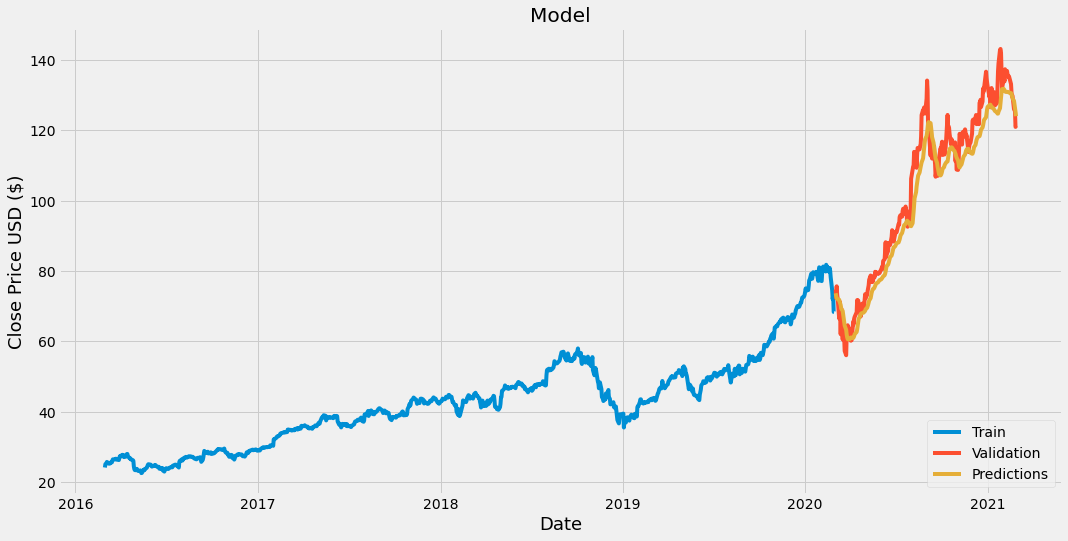

In [51]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

# Blue will indicate what the model was trained on
# Red is actual closing values
# Yellow is the prediction

In [52]:
# Show the actual prices and predicted prices
valid

,close,Predictions
Date,,
2020-03-02,74.702499,73.718216
2020-03-03,72.330002,72.920891
2020-03-04,75.684998,72.317741
2020-03-05,73.230003,72.138039
2020-03-06,72.257500,72.019791
...,...,...
2021-02-22,126.000000,128.395828
2021-02-23,125.860001,127.416145
2021-02-24,125.349998,126.366280


In [ ]:
# Lets try and predict the Dec 31st price 
# Get the quote
# tesla_quote = web.DataReader('SOS', data_source='yahoo', start='2010-01-01', end='2021-2-26')

# # Create new df
# new_df = tesla_quote.filter(['Close'])

# # Get the last 60 day closing price values and convert df to an array
# last_60_days = new_df[-60:].values

# # Scale the data to be values between 0 and 1
# last_60_days_scaled = scaler.transform(last_60_days)

# # Create an empty list
# X_test = []

# # Append last 60 days that were scaled
# X_test.append(last_60_days_scaled)

# # Convert the X_test dataset to numpy aray
# X_test = np.array(X_test)

# # Reshape the data
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# # Get the predicted scaled price
# pred_price = model.predict(X_test)

# # Undo the scaling
# pred_price = scaler.inverse_transform(pred_price)
# print(pred_price)

In [ ]:
# Get the quote
# tesla_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-12-31', end='2020-12-31')
# print(tesla_quote2['Close'])